In [7]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt

# plt.style.use('seaborn')
%matplotlib inline

In [8]:
# вспомогательная функция
def plot_one_image(src_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение.
    
    :param src_image: np.ndarray: исходное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 1, figsize=(6*2, 4*2), constrained_layout=True)
    ax1 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    plt.show()

In [9]:
def plot_transform_result(src_image, transform_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение и его преобразование.
    
    :param src_image: np.ndarray: исходное изображение
    :param transform_image: np.ndarray: преобразованное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 2, figsize=(6.4*2, 4.8*2), constrained_layout=True)
    ax1, ax2 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    ax2.set_title('Результат преобразования')
    ax2.imshow(transform_image, cmap=cmap)
    ax2.set_xticks([]), ax2.set_yticks([])
    plt.show()

In [10]:
def del_cont(image, size=100, inverse=True, col = 0, pad=True):
    im = image.copy()
    if inverse:
        if pad:
            im = np.pad(im, 1, constant_values=col)
        im = np.uint8((im == 0)*255)
    elif pad:
        im = np.pad(im, 1, constant_values=255-col)
    
    h, w = im.shape
    ny = h//size+1
    nx = w//size+1
    laddy = [0, size//4, size//2, size*3//4]
    laddx = [0, size//4, size//2, size*3//4]
    for addy in laddy:
        for addx in laddx:
            for i in range(ny):
                for j in range(nx):
                    slicei = im[i*size+addy:(i+1)*size+1+addy, j*size+addx:(j+1)*size+1+addx]
            #             plot_one_image(slice, is_gray=True)
                    contours, hierarchy = cv2.findContours(slicei.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                    temp = cv2.drawContours(slicei, contours, -1, 255, cv2.FILLED)
                    im[i*size+addy:(i+1)*size+1+addy, j*size+addx:(j+1)*size+1+addx] = temp    
     
    if pad:
        im = np.delete(im, w-1, 1)
        im = np.delete(im, h-1, 0)
        im = np.delete(im, 0, 1)
        im = np.delete(im, 0, 0)
    
    return im

In [11]:
def del_splashes(image, size1=11, size2=13):
    h, w = image.shape
    
    res = image.copy()
    d = (size2-size1)//2
    ny = (h-d)//size1 + int((h-d)%size1 != 0)
    nx = (w-d)//size1 + int((w-d)%size1 != 0)
    laddy = [d, d+size1//4, d+size1//2, d+size1*3//4]
    laddx = [d, d+size1//4, d+size1//2, d+size1*3//4]
    for addy in laddy:
        for addx in laddx:
            for i in range(ny):
                for j in range(nx):
#                     y = i*size2 + size2//2+addy
#                     x = j*size2 + size2//2+addx
                    y = i*size1 + size1//2+addy
                    x = j*size1 + size1//2+addx
                    
                    slice1 = image[y-size1//2 : y+size1//2+1, x-size1//2 : x+size1//2+1].copy()
                    slice2 = image[y-size2//2 : y+size2//2+1, x-size2//2 : x+size2//2+1].copy()

                    hist1 = cv2.calcHist([slice1], [0], None, [255], [0, 255])
                    hist2 = cv2.calcHist([slice2], [0], None, [255], [0, 255])
                    hist = hist2-hist1
                    cols = np.where((hist == 0) & (hist1 != 0))[0]
                    if not len(cols):
                        continue

                    hist1[cols] = 0
                    max_col = np.argmax(hist1)
                    for col in cols:
                        slice1[slice1 == col] = max_col
                    res[y-size1//2 : y+size1//2+1, x-size1//2 : x+size1//2+1] = slice1
    return res

In [12]:
def jackal(image, size=9):
    h, w = image.shape
    
    res = image.copy()
    ny = h//size+1
    nx = w//size+1
    for i in range(ny):
        for j in range(nx):
            y = i*size + size//2
            x = j*size + size//2
                    
            slice1 = image[y-size//2 : y+size//2+1, x-size//2 : x+size//2+1].copy()

            hist1 = cv2.calcHist([slice1], [0], None, [255], [0, 255])
            max_col = np.argmax(hist1)
            slice_jackal = np.ones(slice1.shape)*max_col
            res[y-size//2 : y+size//2+1, x-size//2 : x+size//2+1] = slice_jackal
    return res

In [13]:
def resize(image, k):
    old_h, old_w = image.shape
    im = image[:old_h - old_h%k, :old_w - old_w%k]
    h, w = im.shape
    print(h, w)

    ny = h//k
    nx = w//k
    res = np.zeros((ny, nx))
    for i in range(ny):
        for j in range(nx):
            y = i*k
            x = j*k
                    
            slice1 = image[y : y+k+1, x : x+k+1].copy()

            hist1 = cv2.calcHist([slice1], [0], None, [255], [0, 255])
            max_col = np.argmax(hist1)
            res[i][j] = max_col
    return res.astype(np.uint8)

In [14]:
def get_start(mask, col = 0):
    h, w = mask.shape
    for i in range(1, max(h,w)):
        if np.any(mask[:i+2, :i+1] == col):
            max_x = i+1 if i+1 < w else w-1
            max_y = i+2 if i+2 < h else h-1
            for x in range(max_x):
                for y in range(max_y):
                    if mask[y][x] == col:
                        return y, x
    return -1, -1

In [15]:
def del_im_border(image, mask, del_col=255):
    h, w = image.shape
    corners = [[0,0], [h-1,0], [0,w-1], [h-1,w-1]]
    new_mask = mask.copy()
    temp_im = image.copy()
    for corner in corners:
        y0, x0 = corner
        if image[y0][x0] != 0:
            continue
        
        queue = [[y0,x0]]
        while queue != []:
            y,x = queue[0]
            queue.pop(0)
            temp_im[y][x] = 1
            
            min_y = y-1 if y>0 else y
            max_y = y+1 if y<h-1 else y
            min_x = x-1 if x>0 else x
            max_x = x+1 if x<w-1 else x

            for yi in range(min_y, max_y+1):
                for xi in range(min_x, max_x+1):
                    new_mask[yi][xi] = del_col
                    if not([yi, xi] in queue) and temp_im[yi][xi] == 0:
                        queue.append([yi, xi])
    return new_mask

In [16]:
# def clockwise()
def counterclockwise(centr, point):
    y0, x0 = centr
    y, x = point
    if abs(y - y0) > 1 or abs(x - x0) > 1:
        return -1, -1
    
    if y - y0 == 0 and x - x0 == 0:
        return -1, -1
    
    dx = x - x0
    dy = y - y0
    
    x1 = x+dy if abs(x+dy-x0) < 2 else x
    y1 = y-dx if abs(y-dx-y0) < 2 else y
    return y1, x1

In [17]:
# res = np.zeros((5,5))
# res[2][2] = 255
# col = 0
# h = 255//8
# x0, y0 = 1,1
# y, x = counterclockwise((2,2), (y0, x0))
# print(y, x)
# i = 0
# while y != y0 or x != x0:
#     if i > 20:
#         break
#     col += h
#     res[y][x] = col
#     y, x = counterclockwise((2,2), (y, x))
#     print(y, x)
#     i += 1
# plot_one_image(res, is_gray=True)

In [18]:
def counterclockwise_count_times(centr, point, count):
    y, x = point
    for i in range(count):
        y, x = counterclockwise(centr, [y,x])
    return y, x

In [19]:
# res = np.zeros((5,5))
# res[2][2] = 255
# col = 0
# h = 255//8
# x0, y0 = 1,1
# y, x = counterclockwise_count_times((2,2), (y0, x0), 2)
# print(y, x)
# i = 0
# while y != y0 or x != x0:
#     if i > 20:
#         break
#     col += h
#     res[y][x] = col
#     y, x = counterclockwise_count_times((2,2), (y, x), 2)
#     print(y, x)
#     i += 1
# plot_one_image(res, is_gray=True)

In [20]:
# res = np.zeros((3,3))
# res[1][1] = 255
# col = 0
# h = 255//8
# x0, y0 = 0,0
# y, x = counterclockwise((1,1), (y0, x0))
# while y != y0 or x != x0:
#     col += h
#     res[y][x] = col
#     y, x = counterclockwise((1,1), (y, x))

# plot_one_image(res, is_gray=True)

# get_next_straight(res, [0,1], [[-1,1], [-1,0]])

In [168]:
def area_counterclockwise_count_times(area, count):
    new_area = np.zeros_like(area)
    new_area[1][1] = area[1][1]
    for y in range(0, 3):
        for x in range(0, 3):
            if y == 1 and x == 1:
                continue
            new_y, new_x = counterclockwise_count_times((1,1), [y,x], count)
            # print(y, x, new_y, new_x)
            new_area[new_y][new_x] = area[y][x]
    return new_area

In [229]:
def get_next_tail_points(next_point):
    y, x = next_point
    if y == 0 or x == 0:
        return [[1, 1], [0, 1]]
#         t_p = counterclockwise_count_times((0,0), next_point, 6)
#         return [counterclockwise((0,0), t_p), t_p]

    return [[0, 1]]
#     return [counterclockwise_count_times((0,0), next_point, 7)]

In [230]:
def get_min_h_point(area, t_cols):
    minh = 256
    minx, miny = -2,-2
    x, y = 1, -1

    for i in range(5):
        for col in t_cols:
            h = abs(col - area[y+1][x+1])
            if h < minh:
                minh = h
                minx, miny = x, y
        y, x = counterclockwise((0,0), [y,x]) 
    return minh, miny, minx

In [231]:
def get_last_tail_point(area, old_next, t_cols, sea_cols):
    next = old_next
    for i in range(8):
        new_next_y, new_next_x = counterclockwise((0,0), next)
        col_point = area[new_next_y+1][new_next_x+1]

        for t_col in t_cols:
            t_h = abs(t_col - col_point)
            if t_h < 5:
                next = [new_next_y, new_next_x]
                break
        else:
            if col_point < min(sea_cols)-30 or col_point > max(sea_cols)+30:
                next = [new_next_y, new_next_x]
                continue
            break
    return next

In [232]:
def get_next_in_area(area, t_cols, sea_cols):
    minh, miny, minx = get_min_h_point(area, t_cols)
    if minh < 10:
        next = [miny, minx]
    else:
        next = [0, 1]
        
    next = get_last_tail_point(area, next, t_cols, sea_cols)
    next = counterclockwise((0,0), next)
    return next

In [233]:
def get_next_diagonal(area, prev_point, tail_points, draw = False):
    tail_point = tail_points[0]
    count_turn = 0
    y1, x1 = prev_point
    if y1 == -1:
        count_turn = 4
        if x1 == 1:
            count_turn += 2
    elif x1 == -1: 
        count_turn = 2
    
    new_area = area_counterclockwise_count_times(area, count_turn)
    
    tail_y, tail_x = counterclockwise_count_times((0,0), tail_point, count_turn)

    mirroring = tail_y != 0
    if mirroring:
        new_area = new_area.T

    if draw:
        print("diag")
        print(tail_y, tail_x)
        plot_one_image(new_area, is_gray=True)
        print(new_area)
    
    new_area = new_area.astype(np.int32)
    tail2_y, tail2_x = 0, 1
    
    sea_col1 = new_area[1][1]
    sea_col2 = new_area[2][2]
    sea_col3 = new_area[2][1]
    sea_cols = [sea_col1, sea_col2, sea_col3]
    t_cols = [new_area[tail_y+1][tail_x+1]]

    next = get_next_in_area(new_area, t_cols, sea_cols)      
        
    new_tail_points = get_next_tail_points(next)
    
    tail_points = []
    for tail_point in new_tail_points:
        y, x = tail_point
        if mirroring:
            y, x = x, y
        
        tail_points.append(counterclockwise_count_times((0,0), [y,x], 8-count_turn))
     
    if mirroring:
        next = [next[1], next[0]]
    next = counterclockwise_count_times((0,0), next, 8-count_turn)
    

    return next, tail_points

In [234]:
def get_next_straight(area, prev_point, tail_points, draw = False):
    # if draw:
    #     plot_one_image(area, is_gray=True)
    #     plot_one_image(mask_area, is_gray=True)
    tail_point1 = tail_points[0]
    tail_point2 = tail_points[1]
    count_turn = 0

    y1, x1 = prev_point
    if y1 == -1:
        count_turn = 4
    elif x1 == -1: 
        count_turn = 2
    elif x1 == 1:
        count_turn = 6
    
    new_area = area_counterclockwise_count_times(area, count_turn)
    
    tail1_y, tail1_x = counterclockwise_count_times((0,0), tail_point1, count_turn)
    tail2_y, tail2_x = counterclockwise_count_times((0,0), tail_point2, count_turn)

    if draw:
        print("straight")
        plot_one_image(new_area, is_gray=True)
        print(new_area)
        
    mirroring = tail1_x != 1
    if mirroring:
        new_area = np.flip(new_area, axis=1)
    
    tail1_y, tail1_x = 1, 1
    tail2_y, tail2_x = 0, 1
    t_col1 = new_area[tail1_y+1][tail1_x+1]
    t_col2 = new_area[tail2_y+1][tail2_x+1]
    t_cols = [t_col1, t_col2]
    
    sea_col1 = new_area[1][1]
    sea_col2 = new_area[2][1]
    sea_cols = [sea_col1, sea_col2]

    new_area = new_area.astype(np.int32)
    
    next = get_next_in_area(new_area, t_cols, sea_cols) 
           
    new_tail_points = get_next_tail_points(next)
    
    tail_points = []
    for tail_point in new_tail_points:
        y, x = tail_point
        if mirroring:
            x = -x
        tail_points.append(counterclockwise_count_times((0,0), [y, x], 8-count_turn))
       
    if mirroring:
        next = [next[0], -next[1]]
    next = counterclockwise_count_times((0,0), next, 8-count_turn)
    

    return next, tail_points

In [235]:
def get_next(area, prev_point, tail_points, draw=False):
    """
    prev_point - [y=[-1: 1], x=[-1: 1]]
    """
    y1, x1 = prev_point
    if abs(y1)+abs(x1) == 2:
        return get_next_diagonal(area, prev_point, tail_points, draw)
    return get_next_straight(area, prev_point, tail_points, draw)    

In [236]:
def get_start_values(image, mask):
    h, w = image.shape
    starty, startx = get_start(mask)
    if startx < w//2:
        if mask[starty-1][startx+1] == 0:
            return [starty, startx], [starty-1, startx+1], [[0, 1]]
        if mask[starty][startx+1] == 0:
            if starty > h//2: 
                return [starty, startx], [starty, startx+1], [[-1, 1], [-1, 0]]
            else:
                return [starty, startx], [starty, startx+1], [[1, 1], [1, 0]]
        if mask[starty+1][startx+1] == 0:
            return [starty, startx], [starty+1, startx+1], [[0, 1]]

        if mask[starty-1][startx] == 0:
            return [starty, startx], [starty-1, startx], [[-1, 1], [0, 1]]
        if mask[starty+1][startx] == 0:
            return [starty, startx], [starty+1, startx], [[1, 1], [0, 1]]
    return [-1, -1]

In [243]:
def contours(image, count_gauss1 = 1, ksize1=5, g_threshold1 = 150, kresize = 1):
    h, w, _ = image.shape
#     print(image.shape)
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_img = cv2.resize(gray_img.copy(), (w // kresize, h // kresize))
#     plot_one_image(gray_img)
#     gray_img = cv2.GaussianBlur(gray_img, ksize=(ksize1, ksize1), sigmaX=1, sigmaY=1)
#     gray_img = cv2.GaussianBlur(gray_img, ksize=(ksize1, ksize1), sigmaX=1, sigmaY=1)
    jackal_size = 9
    gray_img = del_splashes(gray_img, size1 = jackal_size, size2 = jackal_size+4)
#     gray_img = jackal(gray_img, size = jackal_size)
    

    gray_img = resize(gray_img, jackal_size)
    plot_one_image(gray_img, is_gray=True)
    
    gx = cv2.Sobel(gray_img, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(gray_img, cv2.CV_32F, 0, 1, ksize=1)
    mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
    
    
    values, counts = np.unique(mag, return_counts=True)
    a = counts.mean()
    ind = len(counts) - 1 - np.where(counts[::-1] >= a)[0][0]
    max_mag = values[ind]

    
    res = np.uint8((mag <= max_mag)*255)
#     plot_one_image(res, is_gray=True)
    temp = del_cont(res, 7, False)
    if np.all(temp == 255):
        res = del_cont(res, 5, False)
    else:
        res = temp
    res = del_im_border(gray_img, res, 255)
    
    
    start_point, point, tail_points = get_start_values(gray_img, res) 
    board = [start_point, point]
    prev_point = [ start_point[0] - point[0],  start_point[1] - point[1] ]

    for i in range(4):
        # print(point)
        y, x = point
        draw = i == 1
#         draw = False
        if draw:
            print(point)
#         print(point)
            print(tail_points)
        point, tail_points = get_next(gray_img[y-1:y+2, x-1:x+2], prev_point, tail_points, draw)
        prev_point = -point[0], -point[1]
        point = y+point[0], x+point[1]
        board.append(point)

    # y, x = [7,6]
    # prev_point = [0, -1] 
    # tail_points = 
    # point, tail_points = get_next(gray_img[y-1:y+2, x-1:x+2], res[y-1:y+2, x-1:x+2], prev_point, tail_points)
    # board.append(point)

    im = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)
    for point in board:
        im[point[0]][point[1]] = (255, 0, 0)
    # cv2.circle(im, (startx, starty), 1, (255, 0, 0), thickness=1)
    
#     plot_one_image(im)
        
    plot_one_image(im)

image 0
450 1050
450 1044


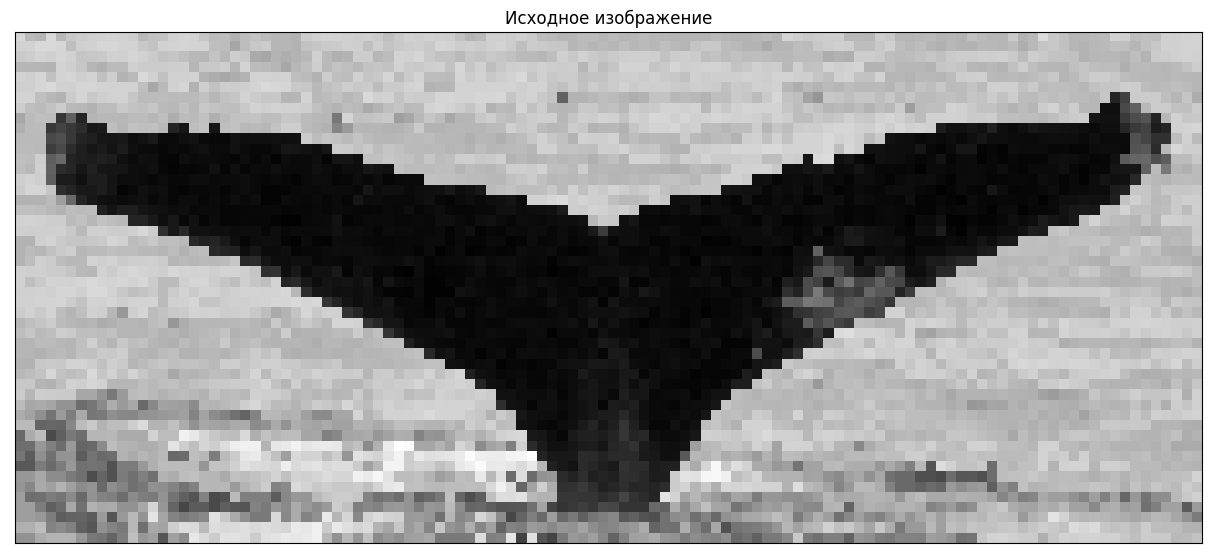

(7, 6)
[(1, -1), (1, 0)]
straight


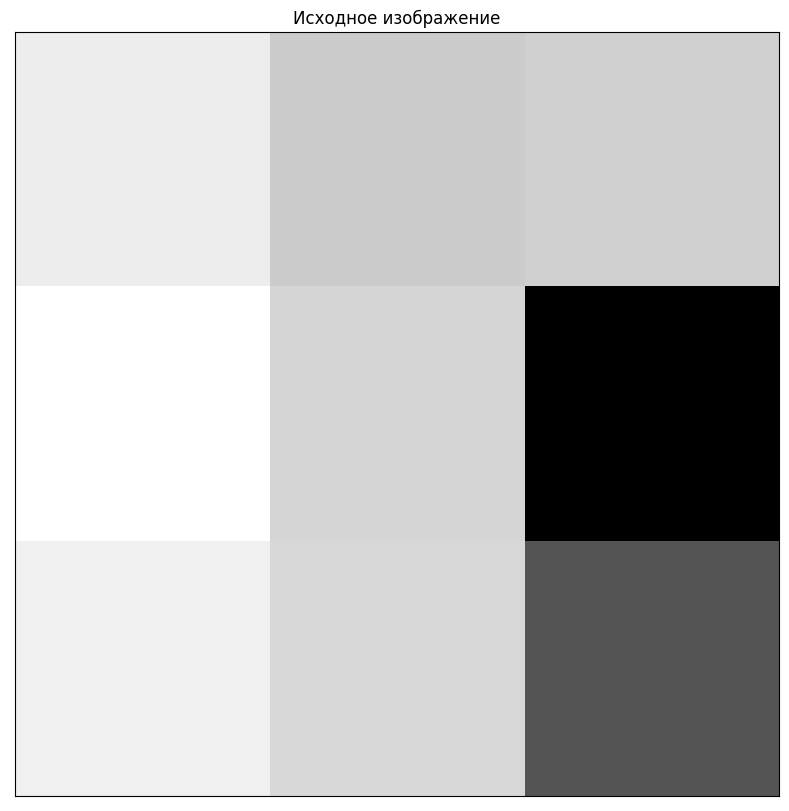

[[195 173 176]
 [207 179  40]
 [197 181  95]]


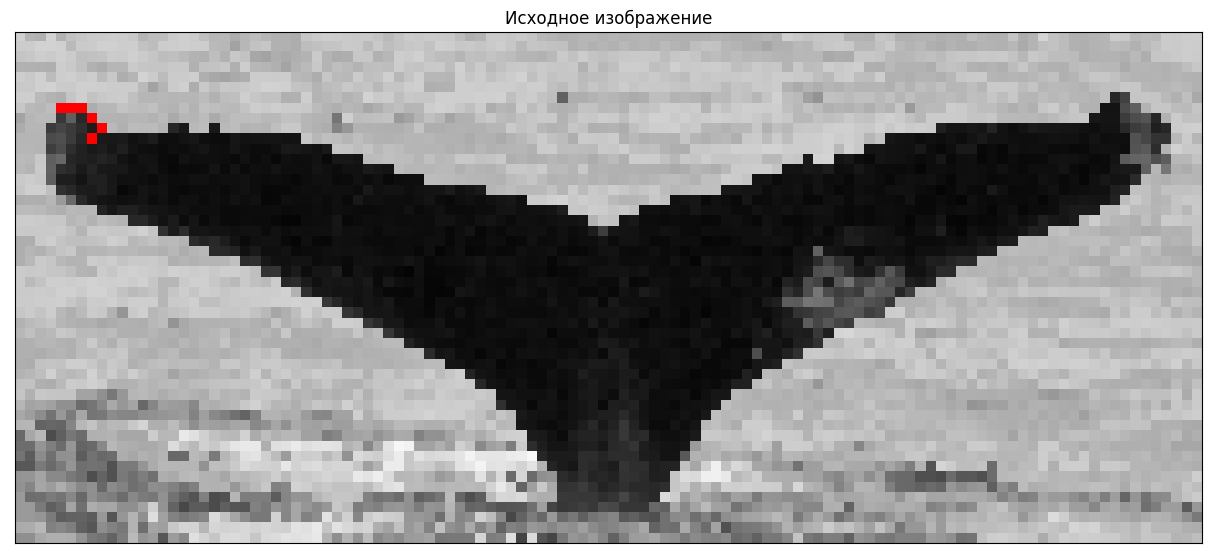

In [244]:
go_i(0)

In [31]:
def go(image):
    h, w, _ = image.shape
    image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
    print(h, w)
    # grayscale
#     gray = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY)
    
    contours(image, count_gauss1 = 1, ksize1=3, g_threshold1 = 100, kresize = 1)

In [32]:
def go_i(num=-1):
    if num == -1:
        for i in range(0, 10):
            if i == 4 or i == 5 or i == 9:
                continue
            print(f"image {i}")
            image = cv2.imread(f'whale_tail/test_image_0{i}.jpg')
            go(image)
            print("----------------")
        for i in range(10, 12):
            print(f"image {i}")
            image = cv2.imread(f'whale_tail/test_image_{i}.jpg')
            go(image)
            print("----------------")
    else:
        print(f"image {num}")
        if num < 10:
            image = cv2.imread(f'whale_tail/test_image_0{num}.jpg')
        else:
            image = cv2.imread(f'whale_tail/test_image_{num}.jpg')
        go(image)